## Linear Elastic Fracture Mechanics

In this notebook, we analyze the stress and displacement fields around a crack tip using Finite Element Method. We will use the LEFM (Linear Elastic Fracture Mechanics) theory to compare the results with the analytical solutions.


- Griffith’s criterion, \( G \) and \( G_c \)
- Stress field near crack tip

**In-Class Problem**

- Compute \( G \) in cracked vs uncracked bar (1D/2D)
- Compare FEM and analytical results

**Learning Outcome**

- Quantify fracture behavior from energy perspective


In [6]:
#| code-fold: true
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import jax.numpy as jnp
from jax import Array

import femsolver
from femsolver.utils import auto_vmap, vmap
from femsolver import Mesh, Operator, element
from femsolver.plotting import STYLE_PATH, colors

import gmsh
import numpy as np
import meshio

import equinox as eqx
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt

In [8]:
#| code-fold: true
#| output: false

def get_elements_on_curve(mesh, curve_func, tol=1e-3):
    coords = mesh.coords
    elements_2d = mesh.elements
    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return jnp.array([], dtype=int)
    
    return jnp.array(elements_1d)

def generate_cracked_plate_mesh(
    length: float,
    height: float,
    lc: float,
    min_elem: float,
    output_filename: str = "model.msh"
):
    """
    Generates a 2D mesh using the Gmsh Python API based on the provided .geo script.

    Args:
        length (float): Total length 'L' of the domain.
        height (float): Total height 'H' of the domain.
        lc (float): Characteristic length 'l' for the initial point.
        min_elem (float): Minimum element size for the refinement box.
        output_filename (str): Name of the output mesh file (e.g., 'model.msh').
    """
    gmsh.initialize()
    gmsh.model.add("refined_plate")

    # --- Use OpenCASCADE geometry kernel ---
    #gmsh.model.setFactory("OpenCASCADE")
    
    # --- Define script parameters ---
    h2 = 1.0
    epsilon = 1e-5
    depth = 0.0

    # --- Define geometry points ---
    # The last argument is the prescribed mesh size at that point.
    gmsh.model.geo.addPoint(0, epsilon, -depth / 2, h2, 1)
    gmsh.model.geo.addPoint(lc, 0, -depth / 2, h2, 2)
    gmsh.model.geo.addPoint(0, -epsilon, -depth / 2, h2, 6)
    gmsh.model.geo.addPoint(0, -height / 2, -depth / 2, h2, 7)
    gmsh.model.geo.addPoint(length, -height / 2, -depth / 2, h2, 8)
    gmsh.model.geo.addPoint(length, height / 2, -depth / 2, h2, 9)
    gmsh.model.geo.addPoint(0, height / 2, -depth / 2, h2, 10)
    gmsh.model.geo.addPoint(length, 0, -depth / 2, h2, 11)

    # --- Define lines connecting the points ---
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 11, 2)
    gmsh.model.geo.addLine(11, 9, 6)
    gmsh.model.geo.addLine(9, 10, 7)
    gmsh.model.geo.addLine(10, 1, 8)
    gmsh.model.geo.addLine(2, 6, 9)
    gmsh.model.geo.addLine(6, 7, 10)
    gmsh.model.geo.addLine(7, 8, 11)
    gmsh.model.geo.addLine(8, 11, 12)

    # --- Define curve loops and surfaces ---
    # A negative tag in a loop reverses the line's direction.
    gmsh.model.geo.addCurveLoop([1, 2, 6, 7, 8], 1)
    gmsh.model.geo.addCurveLoop([9, 10, 11, 12, -2], 2)
    
    gmsh.model.geo.addPlaneSurface([1], 1)
    gmsh.model.geo.addPlaneSurface([2], 2)

    # Synchronize the CAD kernel with the Gmsh model
    gmsh.model.geo.synchronize()

    # --- Define Physical Groups ---
    # Physical groups are used to identify boundaries and domains.
    # Physical Line(2) = {{2}};
    gmsh.model.addPhysicalGroup(1, [2], 2) # dim=1 for lines
    # Physical Surface(1) = {{1, 2}};
    gmsh.model.addPhysicalGroup(2, [1, 2], 1) # dim=2 for surfaces

    # --- Define Mesh Refinement Field ---
    # Create a 'Box' field to control mesh size in a specific region.
    field_tag = gmsh.model.mesh.field.add("Box")
    
    mesh_size_inside_box = min_elem
    mesh_size_outside_box = min_elem * 10
    
    gmsh.model.mesh.field.setNumber(field_tag, "VIn", mesh_size_inside_box)
    gmsh.model.mesh.field.setNumber(field_tag, "VOut", mesh_size_outside_box)
    
    gmsh.model.mesh.field.setNumber(field_tag, "XMin", lc/2)
    gmsh.model.mesh.field.setNumber(field_tag, "XMax", 5*lc)
    gmsh.model.mesh.field.setNumber(field_tag, "YMin", -lc)
    gmsh.model.mesh.field.setNumber(field_tag, "YMax", lc)
    gmsh.model.mesh.field.setNumber(field_tag, "ZMin", 0)
    gmsh.model.mesh.field.setNumber(field_tag, "ZMax", 0)
    gmsh.model.mesh.field.setNumber(field_tag, "Thickness", 2.5e-2)
    
    # Set this field as the background field, which Gmsh uses to drive mesh generation.
    gmsh.model.mesh.field.setAsBackgroundMesh(field_tag)

    # --- Set global mesh options ---
    # These options prevent Gmsh from overriding the background field.
    gmsh.option.setNumber("Mesh.CharacteristicLengthFromPoints", 0)
    gmsh.option.setNumber("Mesh.CharacteristicLengthFromCurvature", 0)
    gmsh.option.setNumber("Mesh.CharacteristicLengthExtendFromBoundary", 0)
    
    # --- Generate the 2D mesh ---
    gmsh.model.mesh.generate(2)

    # --- Save the mesh and optionally launch the GUI ---
    gmsh.write(output_filename)
    print(f"Mesh saved to '{output_filename}'")
    gmsh.finalize()


    _mesh = meshio.read(output_filename)

    #contact_nodes = _mesh.cell_sets_dict["Half-Circle Arc"]["line"]


    mesh = Mesh(
        coords=_mesh.points[:, :2],
        elements=_mesh.cells_dict["triangle"],
    )

    return mesh



We generate a plate with a crack of length $l_c$. We further refine the mesh near the crack tip and along the plane of symmetry.  

In [9]:
#| output: false

crack_length = 0.01
length = 0.2
height = 0.1

params = {
    "length": length,
    "height": height,
    "lc": crack_length,
    "min_elem": 5e-4,
    "output_filename": "refined_model.msh",
}

mesh = generate_cracked_plate_mesh(**params)


n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 60%] Meshing curve 9 (Line)
Info    : [ 70%] Meshing curve 10 (Line)
Info    : [ 80%] Meshing curve 11 (Line)
Info    : [ 90%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.012175s, CPU 0.013586s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.203558s, CPU 0.204721s)
Info    : 6940 nodes 14004 elements
Info    : Writing 'refined_model.msh'...
Mesh saved to 'refined_model.msh'
Info    : Done writing 'refined_model.msh'



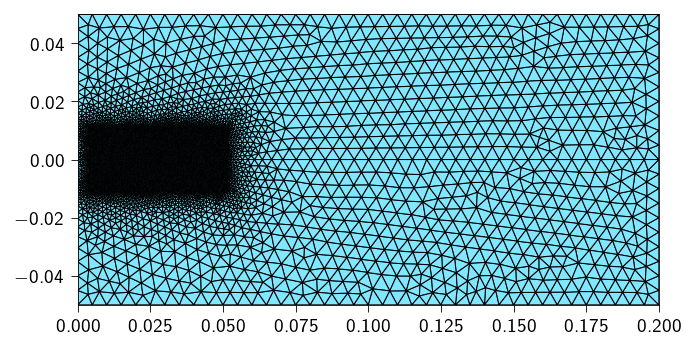

In [10]:
# | code-fold: true
# | fig-align: center

plt.style.use(STYLE_PATH)
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    facecolors=jnp.ones(mesh.elements.shape[0]),
    edgecolors="k",
    lw=0.5,
    cmap=cmc.managua_r,
)

ax.set_aspect("equal")
ax.margins(0.0, 0.0)
plt.show()

### Defining total energy 

We assume a linear elastic material with a linear relationship between stress and strain.

In [11]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


tri = element.Tri3()
op = Operator(mesh, tri)
mat = Material(mu=1.0, lmbda=1.0)

In [12]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.swapaxes(-1, -2))

@auto_vmap(eps=2)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(eps * sig)


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)


@jax.jit
def total_energy(u_flat):
    u = u_flat.reshape(-1, n_dofs_per_node)
    return total_strain_energy(u)


Now, we derive the functions to compute the internal forces and the stiffness matrix using automatic differentiation.

In [13]:
from femsolver import sparse

In [14]:
sparsity_pattern = sparse.create_sparsity_pattern(mesh, n_dofs_per_node=n_dofs_per_node)


gradient = jax.jacrev(total_energy)
hessian_sparse = sparse.jacfwd(
    jax.jacrev(total_energy), sparsity_pattern=sparsity_pattern
)

### Applying Dirichlet boundary conditions

We apply a prestrain to the top and bottom edges of the plate.

In [15]:
prestrain = 0.01

y_max = np.max(mesh.coords[:, 1])
y_min = np.min(mesh.coords[:, 1])
x_min = np.min(mesh.coords[:, 0])
x_max = np.max(mesh.coords[:, 0])

height = y_max - y_min
applied_displacement = prestrain * height

In [16]:
top_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_max))[0]
bottom_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_min))[0]
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], x_min))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], x_max))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * top_nodes,
        2 * top_nodes + 1,
        2 * bottom_nodes,
        2 * bottom_nodes + 1,
        2 * right_nodes,
    ]
)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

prescribed_values = jnp.zeros(n_dofs)
prescribed_values = prescribed_values.at[2 * top_nodes + 1].set(
    applied_displacement / 2.0
)
prescribed_values = prescribed_values.at[2 * bottom_nodes + 1].set(
    -applied_displacement / 2.0
)

zero_indices, one_indices = sparse.get_bc_indices(sparsity_pattern, fixed_dofs)

In [17]:
#| code-fold: true
import scipy.sparse as sp

def newton_scipy_solver(
    u,
    fext,
    gradient,
    hessian_sparse,
    fixed_dofs,
    zero_indices,
    one_indices,
):
    fint = gradient(u)
    K_sparse = hessian_sparse(u)
    indices = K_sparse.indices

    du = jnp.zeros_like(u)

    iiter = 0
    norm_res = 1.0

    tol = 1e-8
    max_iter = 110

    while norm_res > tol and iiter < max_iter:
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)

        K_data_lifted = K_sparse.data.at[zero_indices].set(0)
        K_data_lifted = K_data_lifted.at[one_indices].set(1)

        K_csr = sp.csr_matrix((K_data_lifted, (indices[:, 0], indices[:, 1])))

        du = sp.linalg.spsolve(K_csr, residual)

        u = u.at[:].add(du)
        fint = gradient(u)
        K_sparse = hessian_sparse(u)
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)
        norm_res = jnp.linalg.norm(residual)
        print(f"  Residual: {norm_res:.2e}")
        iiter += 1

    return u, norm_res

In [18]:
#| output: false

u = jnp.zeros(n_dofs)
fext = jnp.zeros(n_dofs)

n_steps = 10

du_total = prescribed_values / n_steps  # displacement increment
for step in range(n_steps):
    print(f"Step {step+1}/{n_steps}")
    u = u.at[fixed_dofs].set((step + 1) * du_total[fixed_dofs])

    u_new, rnorm = newton_scipy_solver(
        u,
        fext,
        gradient,
        hessian_sparse,
        fixed_dofs,
        zero_indices,
        one_indices,
    )

    u = u_new

u_solution = u.reshape(n_nodes, n_dofs_per_node)

Step 1/10
  Residual: 2.34e-18
Step 2/10
  Residual: 2.63e-18
Step 3/10
  Residual: 2.84e-18
Step 4/10
  Residual: 3.29e-18
Step 5/10
  Residual: 3.48e-18
Step 6/10
  Residual: 3.98e-18
Step 7/10
  Residual: 4.68e-18
Step 8/10
  Residual: 4.90e-18
Step 9/10
  Residual: 5.20e-18
Step 10/10
  Residual: 5.58e-18


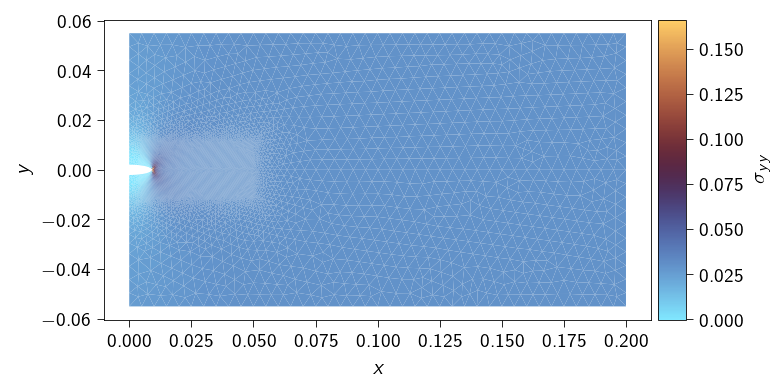

In [39]:
#| code-fold: true

from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_element_values(u, mesh, values, scale=1.0):
    displaced = mesh.coords + scale * u
    tri_elements = mesh.elements

    plt.style.use(STYLE_PATH)
    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()


    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        linewidth=0.0,
        facecolors=values,
        cmap=cmc.managua_r,
        edgecolors="black",
        antialiased=True,
    )
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect("equal")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax, label=r"$\sigma_{yy}$")
    plt.show()


# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)
plot_element_values(u_solution, mesh, stresses[:, 1 , 1].flatten(), scale=10.)

### Comparing numerical results with LEFM theory

In [20]:
#| code-fold: true

import numpy as np

@jax.jit
def find_containing_polygons(
    points: jnp.ndarray,
    polygons: jnp.ndarray,
) -> jnp.ndarray:
    """
    Finds the index of the containing polygon for each point.

    This function uses a vectorized Ray Casting algorithm and is JIT-compiled
    for maximum performance. It assumes polygons are non-overlapping.

    Args:
        points (jnp.ndarray): An array of points to test, shape (num_points, 2).
        polygons (jnp.ndarray): A 3D array of polygons, where each polygon is a
                                list of vertices. Shape (num_polygons, num_vertices, 2).

    Returns:
        jnp.ndarray: An array of shape (num_points,) where each element is the
                     index of the polygon containing the corresponding point.
                     Returns -1 if a point is not in any polygon.
    """

    # --- Core function for a single point and a single polygon ---
    def is_inside(point, vertices):
        px, py = point
        
        # Get all edges of the polygon by pairing vertices with the next one
        p1s = vertices
        p2s = jnp.roll(vertices, -1, axis=0) # Get p_{i+1} for each p_i

        # Conditions for a valid intersection of the horizontal ray from the point
        # 1. The point's y-coord must be between the edge's y-endpoints
        y_cond = (p1s[:, 1] <= py) & (p2s[:, 1] > py) | \
                 (p2s[:, 1] <= py) & (p1s[:, 1] > py)
        
        # 2. The point's x-coord must be to the left of the edge's x-intersection
        # Calculate the x-intersection of the ray with the edge
        x_intersect = (p2s[:, 0] - p1s[:, 0]) * (py - p1s[:, 1]) / \
                      (p2s[:, 1] - p1s[:, 1]) + p1s[:, 0]
        x_cond = px < x_intersect
        
        # An intersection occurs if both conditions are met.
        intersections = jnp.sum(y_cond & x_cond)
        
        # The point is inside if the number of intersections is odd.
        return intersections % 2 == 1

    # --- Vectorize and apply the function ---
    # Create a boolean matrix: matrix[i, j] is True if point i is in polygon j
    # Vmap over points (axis 0) and polygons (axis 0)
    # in_axes=(0, None) -> maps over points, polygon is fixed
    # in_axes=(None, 0) -> maps over polygons, point is fixed
    # We vmap the second case over all points
    is_inside_matrix = jax.vmap(lambda p: jax.vmap(lambda poly: is_inside(p, poly))(polygons))(points)

    # Find the index of the first 'True' value for each point (row).
    # This gives the index of the containing polygon.
    # We add a 'False' column to handle points outside all polygons.
    # jnp.argmax will then return the index of this last column.
    padded_matrix = jnp.pad(is_inside_matrix, ((0, 0), (0, 1)), 'constant', constant_values=False)
    indices = jnp.argmax(padded_matrix, axis=1)
    
    # If the index is the last one, it means the point was not in any polygon.
    # We map this index to -1 for clarity.
    return jnp.where(indices == is_inside_matrix.shape[1], -1, indices)

We now plot the stress field along the line $x=0$. We will use the analytical solution from LEFM to compare with the FEM solution.

The analytical solution for the stress field is given by:

$$
\sigma_{xx} = \frac{K_I}{\sqrt{2\pi r}} \cos(\frac{\theta}{2}) [1- \sin(\frac{\theta}{2}) \sin(\frac{3\theta}{2})]
$$

$$
\sigma_{xy} = \frac{K_I}{\sqrt{2\pi r}} \cos(\frac{\theta}{2}) \sin(\frac{\theta}{2}) \sin(\frac{3\theta}{2})
$$

$$
\sigma_{yy} = \frac{K_I}{\sqrt{2\pi r}} \cos(\frac{\theta}{2}) [1 + \sin(\frac{\theta}{2}) \sin(\frac{3\theta}{2})]
$$

where $K_I$ is the stress intensity factor, $r$ is the distance from the crack tip, and $\theta$ is the angle from the crack tip.

The stress intensity factor $K_I$ for crack in an infinite plate is given by:

$$
K_I = \kappa\sigma_{\infty} \sqrt{\pi a}
$$

where $\sigma_{\infty}$ is the remote stress, $a$ is the crack length and $\kappa$ is a factor that depends on the geometry.

In [32]:
def analytical_stress_field(r, sigma_inf, lc, theta=0, kappa=1.0):
    K_I = kappa * sigma_inf * jnp.sqrt(jnp.pi * lc)
    sigma_xx = (
        K_I
        / jnp.sqrt(2 * jnp.pi * r)
        * jnp.cos(theta / 2)
        * (1 - jnp.sin(theta / 2) * jnp.sin(3 * theta / 2))
    )
    sigma_xy = (
        K_I
        / jnp.sqrt(2 * jnp.pi * r)
        * jnp.cos(theta / 2)
        * jnp.sin(theta / 2)
        * jnp.sin(3 * theta / 2)
    )
    sigma_yy = (
        K_I
        / jnp.sqrt(2 * jnp.pi * r)
        * jnp.cos(theta / 2)
        * (1 + jnp.sin(theta / 2) * jnp.sin(3 * theta / 2))
    )
    return jnp.array([sigma_xx, sigma_xy, sigma_yy]).T

In [35]:
x = np.linspace(crack_length, 5*crack_length, 100)
y = np.full_like(x, fill_value=1e-10)

points = np.stack([x, y], axis=1)
containing_indices = find_containing_polygons(points, mesh.coords[mesh.elements])

stress_field = stresses[containing_indices, :, :]

E = mat.mu * (3*mat.lmbda + 2*mat.mu) / (mat.lmbda + mat.mu)

r = jnp.linalg.norm(points - jnp.array([crack_length, 1e-6]), axis=1)


sigma_inf = prestrain*E
ana_stress_field = analytical_stress_field(r, sigma_inf, crack_length, kappa=1.0)

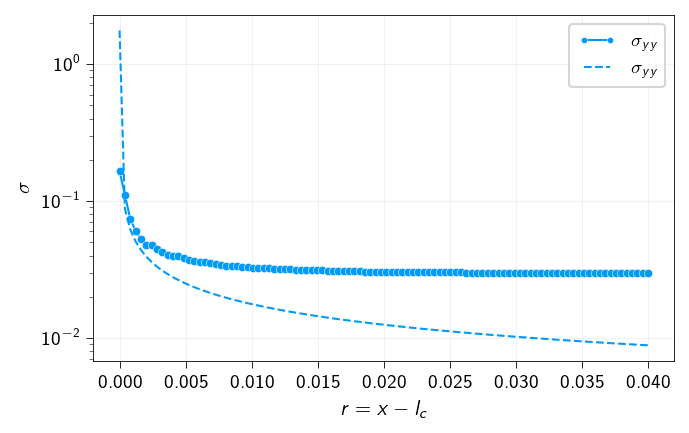

In [36]:
#| code-fold: true
#| fig-align: center
#| fig-cap: "Stress field in front of the crack tip ($y=0$). Comparison with LEFM."

plt.style.use(STYLE_PATH)
plt.figure(figsize=(5, 3))
ax = plt.axes()
ax.semilogy(r, stress_field[:, 1, 1], 'o-', label=r'$\sigma_{yy}$', color=colors.blue)
ax.semilogy(r, ana_stress_field[:, 2], ls='--', label=r'$\sigma_{yy}$', color=colors.blue)
ax.set_xlabel(r'$r = x - l_c$')
ax.set_ylabel(r'$\sigma$')
ax.grid(True)
ax.legend()
plt.show()